# Determination of kinetics of a 2nd Order Reaction using a batch reactor

## Details

Rajas Mehendale

18CHE160

T.Y B.Chem.Engg

ICT, Mumbai


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score 

from IPython.display import display

%config InlineBackend.figure_format = 'retina'

style.use("classic")

## Reaction Conditions



$M = \frac{{C}_{B0}}{{C}_{A0}}$

M greater than 1 for the analysis to hold mathematically.


In [2]:
temp = 30 #centigrade
temp_kel = temp +273.16 #Kelvin
cao = 9.100e-3 #gmol/L
cbo = 1.090e-2 #gmol/L
M = cbo/cao;
lambda_calib = (2.6e-4,-6.3e-5);

## Reading the Excel File using pandas

In [3]:
df = pd.read_excel(
                    "batch_reactor_assignment_data.xlsx",
                    index_col=0
                  )
display(df.head(5))

,Time_sec,YT_mS_per_cm
Sr_No,,
1,15,19.70
2,30,14.05
3,60,10.06
4,90,8.58
5,120,7.87


### Defining the necessary functions

#### Calibration

$${Y}_{{28}^{o}C} = 1+0.0145*(T({}^{o}C) - 28)$$



In [4]:
def calibration(row):
    yt = row["YT_mS_per_cm"]
    y28 = yt*(1 + 0.0145*(temp-28))
    return y28

#### Concentration of B

$$C_{B} = \ \ (\lambda _{1} *{Y}_{{28}^{o}C} ) + \lambda _{2}$$ 

$$C_{B} \ \ in \ \ (\frac{gmol}{L})$$

In [5]:
def conc_b(row):
    y28 = row["Y28"]
    cb = lambda_calib[0]*y28 + lambda_calib[1]
    return cb

#### Concentration of A

$$C_A = C_{A0} - (C_{B0} \ \  - \ \ C_{B})$$

In [6]:
def conc_a(row):
    cb = row["Cb"]
    ca = cao-(cbo-cb)
    return ca

#### Conversion

$${X}_{A} = (\frac{C_{A0} - C_{A}}{C_{A0}})$$

In [7]:
def conversion(row):
    ca = row["Ca"]
    Xa = (cao-ca)/cao
    return Xa

#### Batch Reactor Design Equation



$$t = \ \ \int_{0}^{{X}_{A}} (\frac{d{X}_{A}}{{-r}_{A}})$$


$$t = \ \ \int_{0}^{{X}_{A}} (\frac{d{X}_{A}}{k * {C}_{A} * {C}_{B}})$$

$$t = \ \ \int_{0}^{{X}_{A}} (\frac{d{X}_{A}}{k * {{C}_{A0}}^{2} * (1-{X}_{A}) * (M-{X}_{A})})$$

where 

${C}_{A} ={C}_{A0} * (1- {X}_{A})$

${C}_{B} ={C}_{B0} - \ \ {\nu }_{B} * {C}_{A0} *{X}_{A}$

Here, ${\nu }_{B} =1$


This equation has an analytical solution given by

$$k \ \ * \ \ t \ \  = \frac{1}{{C}_{A0} * (M-1)} * ln [\frac{M - X_A}{M*(1-X_A)}]$$



In [8]:
def plot_func(row):
    Xa = row["Xa"]
    f_xa = (1/(cao*(M-1)))*np.log((M-Xa)/(M*(1-Xa)))
    return f_xa

### Performing calculations

In [9]:
df["Y28"] = df.apply(
                    calibration,
                    axis = 1,
                    )
df["Cb"] = df.apply(
                    conc_b,
                    axis = 1,
                    )
df["Ca"] = df.apply(
                    conc_a,
                    axis = 1,
                    #args= (cao,cbo)
                    )
df["Xa"] = df.apply(
                    conversion,
                    axis = 1,
                    #args= (cao,cbo)
                    )
df["f_Xa"] = df.apply(
                    plot_func,
                    axis = 1,
                    #args= (cao,cbo)
                    )

### Displaying the final table

In [10]:
display(df.head(5))

,Time_sec,YT_mS_per_cm,Y28,Cb,Ca,Xa,f_Xa
Sr_No,,,,,,,
1,15,19.70,20.27130,0.005208,0.003408,0.625545,135.349322
2,30,14.05,14.45745,0.003696,0.001896,0.791655,270.573643
3,60,10.06,10.35174,0.002628,0.000828,0.908961,541.168196
4,90,8.58,8.82882,0.002232,0.000432,0.952473,811.566271
5,120,7.87,8.09823,0.002043,0.000243,0.973347,1083.497287


## Determination of k


The value of k can be determined by linear regression of the form

$$f({X}_{A}) = k \ \ *\ \ t $$

$$where$$

$$f({X}_{A}) = \frac{1}{{C}_{A0} * (M-1)} * ln [\frac{M - X_A}{M*(1-X_A)}]$$

### Using curve_fit to obtain k

In [11]:
def test(x,k_dash): 
    return k_dash*x ## f(xa) = k*t
param, param_cov = curve_fit(test, df["Time_sec"], df["f_Xa"]) 
k = param[0]
print("The value of k is %.4f" %(k) + " (gmol/L)^(-1) * (s)^(-1)")
r_sq = r2_score(df['f_Xa'], test(df['Time_sec'],k))
print("Goodness of fit indicator (R^2) = %0.4f\n" %r_sq)

The value of k is 9.1401 (gmol/L)^(-1) * (s)^(-1)
Goodness of fit indicator (R^2) = 0.9972



## Plotting the Data

### Creating a Regression Line for Plotting

In [12]:
z = np.linspace(0,400,2000);
yy = param[0]*z

### Creating a Plot

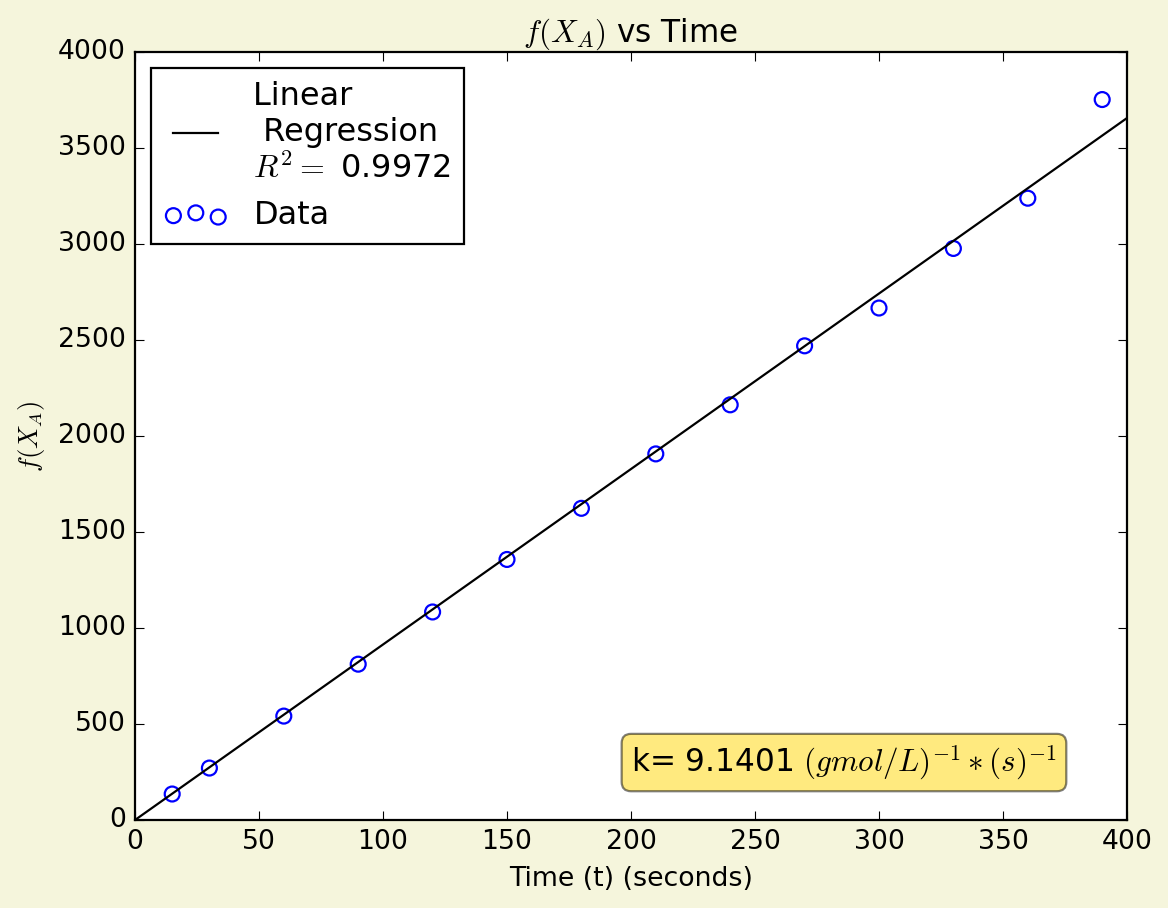

In [13]:
fig = plt.figure(facecolor="beige")
ax = fig.add_subplot(111)
ax.scatter(df["Time_sec"], df["f_Xa"],label ="Data", marker = "o",s=45, edgecolors='b',facecolors = 'none') 
# facecolors = 'none'
ax.plot(z,yy, 'k', label = "Linear \n Regression\n"+r"${R}^{2} =$ %.4f"%(r_sq) )


plt.xlim([0,400]);
plt.ylim([0,4000]);
plt.xlabel("Time (t) (seconds)", fontsize=12)
plt.ylabel(r"$f({X}_{A})$", fontsize=12)
plt.legend(loc="best")
plt.title(r"$f(X_A)$"
          + " vs Time", 
          fontsize=14);


textstr ="k= %.4f " %(k) + r"${(gmol/L)}^{-1}* {(s)}^{-1}$"
props = dict(boxstyle='round', facecolor='gold', alpha=0.5)
ax.text(0.5, 0.1, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);


#plt.savefig("Regression Plot.pdf",bbox_inches='tight')


### Saving the Calculations to an Excel File

In [14]:
df.to_excel("calculations_batch_reactor_assignment.xlsx", sheet_name = 'Calculations')